# POLON -  Polish Scholarly Bibliography analysis, 2017

Full results of this analysis with conclusions and thorough comments have been published in a scientific paper: 

* **Kulczycki, E., Engels, T., Nowotniak., R. (2017). Publication patterns in the social sciences and humanities in Flanders and Poland. In: Proceedings of ISSI 2017 Wuhan: 16th International Society of Scientometrics and Informetrics Conference, Wuhan, China, 16–20 October 2017, pp. 95–104.** -- [[full text PDF]](Publication patterns in the social sciences and humanities in Flanders and Poland.pdf)

<a href="Publication patterns in the social sciences and humanities in Flanders and Poland.pdf"><img src="Kulczycki-Engels-Nowotniak-paper.jpg" style="border: 1px solid black"/></a>

## Initial analysis steps implementation in Python / pandas

Robert Nowotniak  <rnowotniak@gmail.com>

Feb 2nd, 2017

In [1]:
import glob, re
from collections import Counter
import string
import numpy as np
import os, os.path
import pandas as pd
import xml.etree.ElementTree
import matplotlib.pyplot as plt

Fix incorrectly coded Polish characters in the input files names (rename the files accordingly):

In [2]:
trans = str.maketrans('\udcea\udcd1\udcd8\udcf3\udcf5\udca5\udcf9\udcae\udca2\udcbd\udce5\udca0',
                      'łąŁóńżŚęŻźć ')
output = open('renamed.txt', 'w')

for f in glob.glob('ExportData/*.xml'):
    fixed = f.translate(trans)
    try:
        fixed.encode('utf8')
    except UnicodeEncodeError:
        print(repr(fixed))
        break
    if f != fixed:
        print("Renaming " + fixed)
        os.rename(f, fixed)
    output.write("%s\n" % fixed)
    
output.close()

## Rougth initial analysis

In [2]:
%%time

result = []
for f in glob.glob('ExportData/*.xml')[:50]:
    e = xml.etree.ElementTree.parse(f).getroot()
    d = dict(Counter([re.sub(r'{.*}', '', c.tag) for c in e]))
    d['Institute name'] = re.sub(r'.*/', '', f)
    result.append(d)

CPU times: user 944 ms, sys: 38.1 ms, total: 982 ms
Wall time: 1.48 s


In [3]:
df = pd.DataFrame(result)
df = df.fillna(0)

# df = df[['Institute name', 'book', 'chapter', 'article']]

In [4]:
df.head(20)

,Institute name,article,book,chapter
0,AR_Pracownia Ratownictwa Medycznego_Szkoła Głó...,0.0,0.0,0.0
1,RS_Państwowa Wyższa Szkoła Zawodowa w Nysie_RO...,0.0,0.0,0.0
2,S_Wydział Nauk Społecznych_Wyższa Szkoła Gospo...,0.0,0.0,0.0
3,R_Wydział Zarządzania_Wyższa Szkoła Promocji M...,39.0,0.0,0.0
4,R_Wydział Nauk Społecznych_Małopolska Wyższa S...,5.0,4.0,23.0
5,R_Uczelnia Jana Wyżykowskiego_ROOT_2742.xml,158.0,11.0,124.0
6,RS_Wydział Kompozycji Dyrygentury i Teorii Muz...,0.0,0.0,0.0
7,RS_Wydział Mechaniczny_Politechnika Koszalińsk...,0.0,0.0,0.0
8,AR_Kolegium Pedagogiczne_Politechnika Śląska_4...,0.0,1.0,0.0
9,RS_Wydział Twórczoci Interpretacji i Edukacji ...,0.0,0.0,0.0


In [5]:
df[['book','chapter','article']].sum()

book        846.0
chapter    2511.0
article    4634.0
dtype: float64

In [6]:
df.to_csv('works-stats.csv')

## Works IDs analysis (if there are same works with different IDs or vice versa)

In [7]:
e=xml.etree.ElementTree.parse('ExportData/R_Akademia Sztuk Pięknych im Jana Matejki w Krakowie_ROOT_557.xml').getroot()

In [8]:
def ids_and_titles(e):
    result =[]
    #print(e)
    for c in e:
        # if not c.tag.endswith('}chapter'):
        #    continue
        #print(e)
        i = None
        title = None
        for d in c:
            if d.tag.endswith('}system-identifier'):
                i = d.text.lower().strip()
            if d.tag.endswith('}title'):
                title = d.text.lower().strip()
        if not i or not title:
            print("ERROR")
            return
        else:
            result.append({'title':title, 'id':i})
            #print("%s;%s" % (i,title))
    print(len(result))
    return result
    

In [ ]:
df = pd.DataFrame()
for f in glob.glob('ExportData/*.xml'):
    print(f)
    try:
        e = xml.etree.ElementTree.parse(f).getroot()
        df = df.append(pd.DataFrame(ids_and_titles(e)))
    except Exception:
        continue


In [10]:
pd.DataFrame(df.groupby('title').id.nunique()).sort_values('id',ascending=False).to_csv('artsids.txt')

In [11]:
pd.DataFrame(df.groupby('id').title.nunique()).to_csv('artsids.txt')

## Data conversion from input XML files to a single DataFrame

In [12]:
ns = '{http://pbn.nauka.gov.pl/-/ns/bibliography}'

def process_file(f):
    m = re.match(r'^(S|R|RS|AR)_(.*)_\d+\.xml', os.path.basename(f))
    if not m:
        raise Exception()
    
    results = []
    
    record = {}
    record['module'] = m.group(1)
    record['institute'] = m.group(2)
    
    root = xml.etree.ElementTree.parse(f).getroot()
    for w in root:
        record['type'] = re.sub(r'.*}', '', w.tag)
        record['title'] = w.find(ns + 'title').text.strip().lower()
        try:
            record['lang'] = w.find(ns + 'lang').text.strip().lower()
        except Exception:
            record['lang'] = ''
        record['year'] = w.find(ns + 'publication-date')
        if record['year'] != None and record['year'].text != None:
            record['year'] = record['year'].text
            record['year'] = re.sub(r'(\d\d\d\d)-.*', r'\1', record['year'])
        try:
            nothers = int(w.find(ns + 'other-contributors').text)
        except Exception:
            nothers = 0
        if record['type'] == 'book' and w.findall(ns + 'editor'):
            record['type'] = 'edited volume'
        authors = []
        authorselems = w.findall(ns + 'author') + w.findall(ns + 'editor')
        if record['type'] == 'edited volume':
            authorselems = w.findall(ns + 'editor')
        for a in authorselems:
            try:
                fullname  = a.find(ns+'given-names').text.strip().capitalize()
                fullname += ' '
                fullname += a.find(ns+'family-name').text.strip().capitalize()
                authors.append(fullname)
            except Exception:
                # This happens if there is first name or surname information missing in XML
                pass
        record['nauthors'] = len(authors) + nothers
        
        if False: # or 'show data':
            print(record['module'])
            print(record['institute'])
            print(record['lang'])
            print(record['year'])
            print(record['type'] + ': ' + record['title'])
            print(record['nauthors'])
            for a in authors:
                print(a)
            print('--')
            
        for a in authors:
            record['author'] = a
            results.append(dict(record))
    
    return results
      
f = 'ExportData/AR_Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej_126.xml'
process_file(f)

[{'author': 'Marek Konecki',
  'institute': 'Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej',
  'lang': 'pl',
  'module': 'AR',
  'nauthors': 1,
  'title': '"wpływ szybkości wydzielania ciepła i emisji dymu na rozwój pożaru w układzie pomieszczeń"',
  'type': 'book',
  'year': '2009'},
 {'author': 'Marzena Półka',
  'institute': 'Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej',
  'lang': 'en',
  'module': 'AR',
  'nauthors': 1,
  'title': '"influence of the selected flame retardants on the specific fire properties of the epoxy materials made of epidian 561 and epidian 5". rozprawa haibilitacyjna',
  'type': 'book',
  'year': '2011'},
 {'author': 'Zdzisław Salamonowicz',
  'institute': 'Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej',
  'lang': 'pl',
  'module': 'AR',
  'nauthors': 1,
  'title': '"badanie równowag fazowych mieszaniny propan-butan w symulowanych warunkach pożarowych" rozprawa dok

Process all XML input data files into a single DataFrame object

In [ ]:
# %%time
df = pd.DataFrame()
for f in glob.glob('ExportData/*.xml'):
    #print(f)
    try:
        df = df.append(pd.DataFrame(process_file(f)))
    except Exception:
        print("Error: " + f)
    

### Basic sanity checks

If all is fine, then below show return no records.

In [18]:
df[df.lang.str.lower().str.contains('<element')]

,author,institute,lang,module,nauthors,title,type,year


If all is fine, then 'lang' should be empty string in below.

In [19]:
df[df.title.str.startswith('a method for estimating the efficiency of')]

,author,institute,lang,module,nauthors,title,type,year


Write the result to output CSV file.

In [17]:
df.to_csv('data.csv')

In [18]:
# df.to_excel('data.xlsx')

## Main analysis

Warning below can be neglected, there is only some performance impact in data loading stage, but not significant.

In [16]:
%%time
df=pd.read_csv('data.csv.gz',index_col=0)
df=df.fillna('')

CPU times: user 7.08 s, sys: 180 ms, total: 7.26 s
Wall time: 7.26 s


In [17]:
print(df.shape)
df.head()

(1579843, 8)


,author,institute,lang,module,nauthors,title,type,year
0,Ewa Borkowska-bagieńska,Kolegium Pedagogiczne_Politechnika Śląska,pl,AR,2,tożsamość europejczyków,edited volume,2014
1,Beata Wojewoda,Kolegium Pedagogiczne_Politechnika Śląska,pl,AR,2,tożsamość europejczyków,edited volume,2014
0,Tomasz Gawron,Wydział Transportu_Politechnika Śląska,pl,AR,2,optymalna strategia przejazdu monocykla przez ...,article,2014
1,Maciej Michałek,Wydział Transportu_Politechnika Śląska,pl,AR,2,optymalna strategia przejazdu monocykla przez ...,article,2014
2,Szymon Surma,Wydział Transportu_Politechnika Śląska,en,AR,1,network safety in railroad traffic control sys...,article,2009


### Number of records for each module comparison

In [20]:
%matplotlib inline

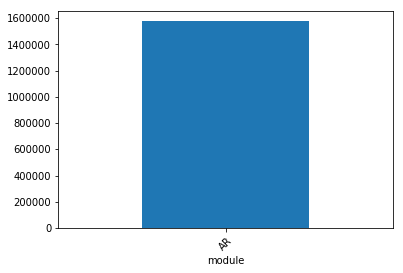

In [21]:
df.groupby('module').size().plot(kind='bar',rot=45)

This means that most records are stored in "R" module, and "AR" is the second.  There are almost no records in "RS" or "S".

## Works distribution by year in "AR" module

In [22]:
df['year'] = df['year'].map(lambda v: int(str(v)[:4])  if re.match(r'^\d\d\d\d.*', str(v)) else None)
df['year'] = df['year'].map(lambda v: None if v < 1950 else v)
df['year'] = df['year'].map(lambda v: None if v > 2017 else v)

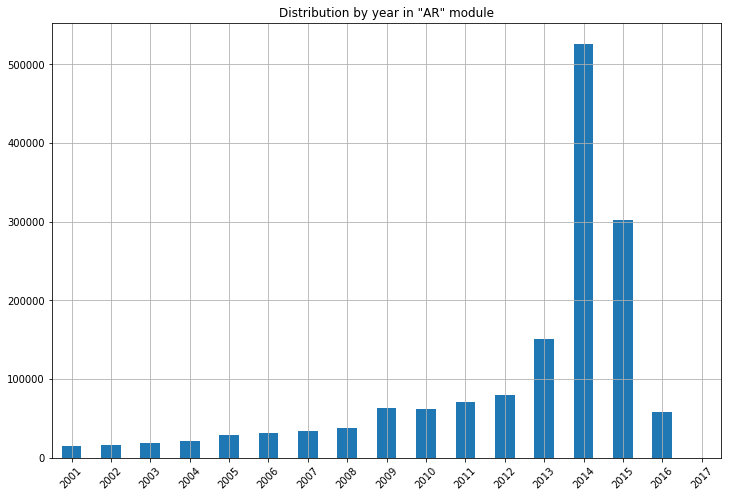

In [29]:
df[(df.module=='AR')&(df.year!=None)&(df.year>2000)]['year'].apply(int).value_counts().sort_index()\
    .plot(kind='bar',rot=45,grid=True, figsize=(12,8))
plt.title('Distribution by year in "AR" module')

## Language analysis

Fix the most common language synonyms.

In [30]:
df['lang'] = df['lang'].apply(lambda v: 'en' if v in \
                 ('english', 'angielski','eng','ang','polski i angielski','angielski i polski', \
                  'dwujęzyczna: polski, angielski', 'en angielski', 'polski, angielski') else v)
df['lang'] = df['lang'].apply(lambda v: 'pl' if v in \
                 ('polski', 'pol', 'polski.') else v)
df['lang'] = df['lang'].apply(lambda v: 'ru' if v in \
                 ('rus', 'rosyjski') else v)
df['lang'] = df['lang'].apply(lambda v: 'de' if v in \
                 ('niemiecki') else v)
df['lang'] = df['lang'].apply(lambda v: 'fr' if v in \
                 ('francuski') else v)
df['lang'] = df['lang'].apply(lambda v: 'uk' if v in \
                 ('ukraiński') else v)
df['lang'] = df['lang'].apply(lambda v: 'es' if v in \
                 ('hiszpański') else v)
df['lang'] = df['lang'].apply(lambda v: 'it' if v in \
                 ('włoski') else v)

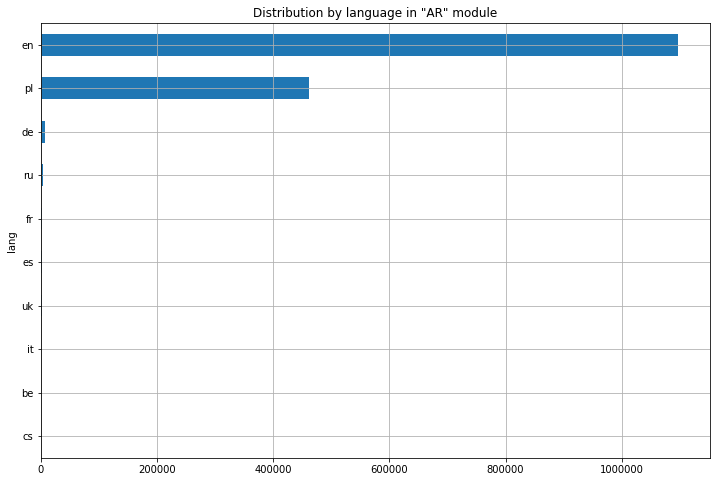

In [34]:
df[df.module=='AR'].groupby('lang').size().sort_values(ascending=True).tail(10).plot.barh(grid=True, figsize=(12,8))
plt.title('Distribution by language in "AR" module')

## Authors who (co-)authored most papers

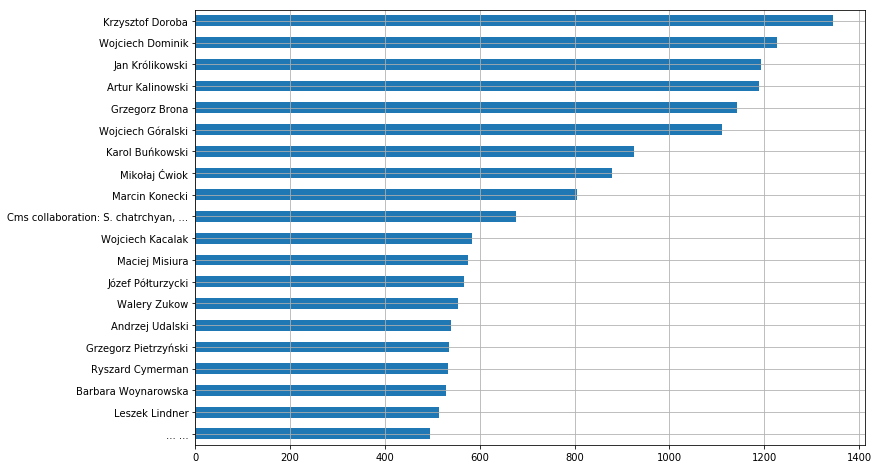

In [36]:
df[df.module=='AR'].author.value_counts(ascending=True).tail(20).plot.barh(grid=True, figsize=(12,8))

## Histogram of publications count by single author

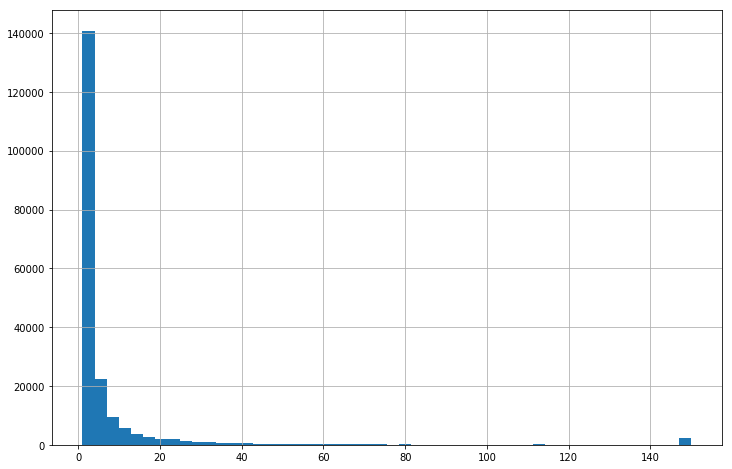

In [38]:
df.author.value_counts().apply(lambda v: min(150,v)).hist(bins=50, figsize=(12,8))

## (Co-)authors count histogram

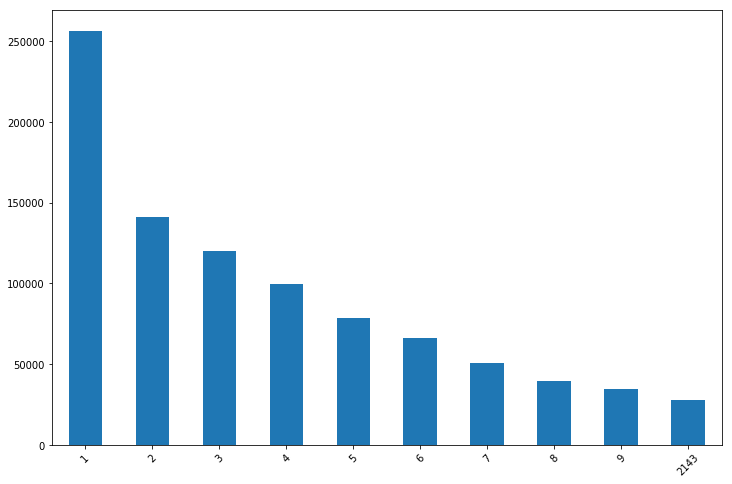

In [39]:
df.nauthors.value_counts().head(10).plot.bar(rot=45, figsize=(12,8))

## Work types distribution

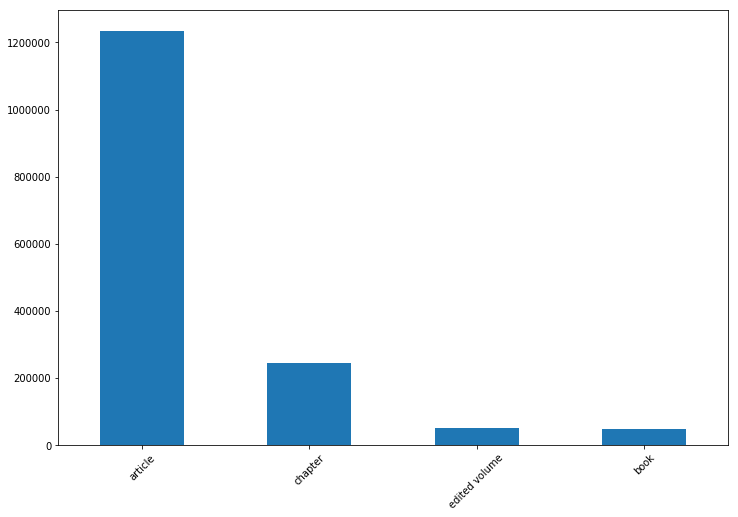

In [40]:
df[df.module=='AR']['type'].value_counts().plot.bar(rot=45, figsize=(12,8))

## Institutes which published most works

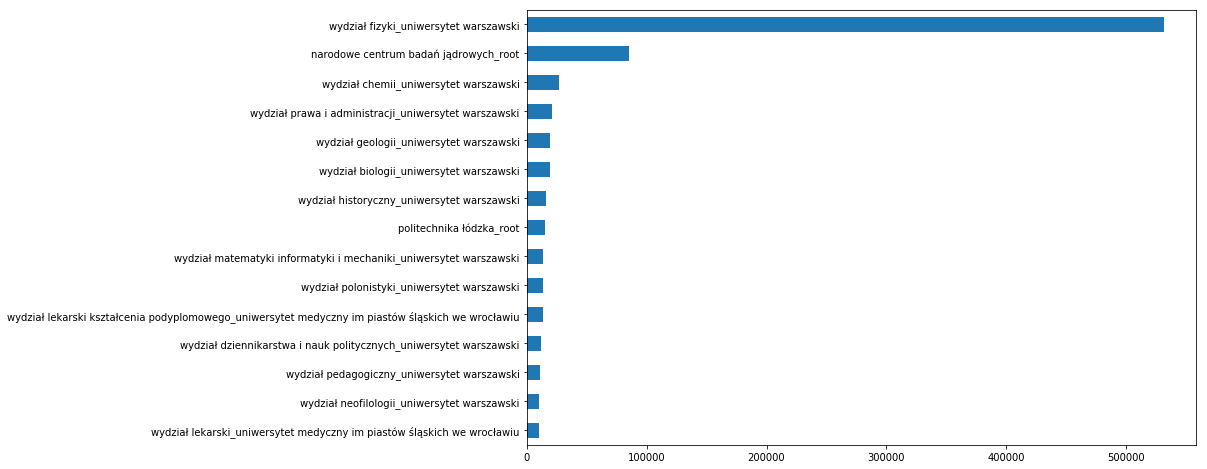

In [42]:
df.institute.str.lower().value_counts(ascending=True).tail(15).plot.barh(figsize=(12,8))

*Remark*:  Absolute values on horizontal axis should not be taken directly (it is actually infuenced by number of co-authors)

## Work types for selected top institutes by year

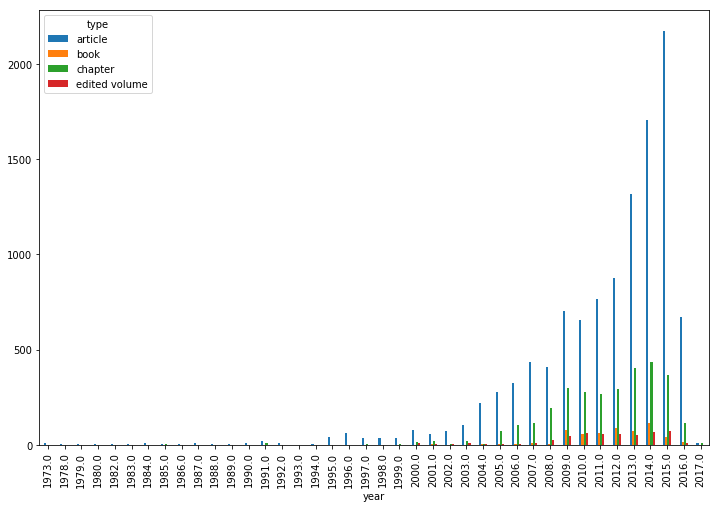

In [48]:
pd.pivot_table(
df[(df.institute.str.lower()=='politechnika łódzka_root') & (df.module=='AR')], \
    values = 'title',
    index='year', columns='type',aggfunc='count').fillna(0).applymap(int).plot.bar(rot=90, figsize=(12,8))

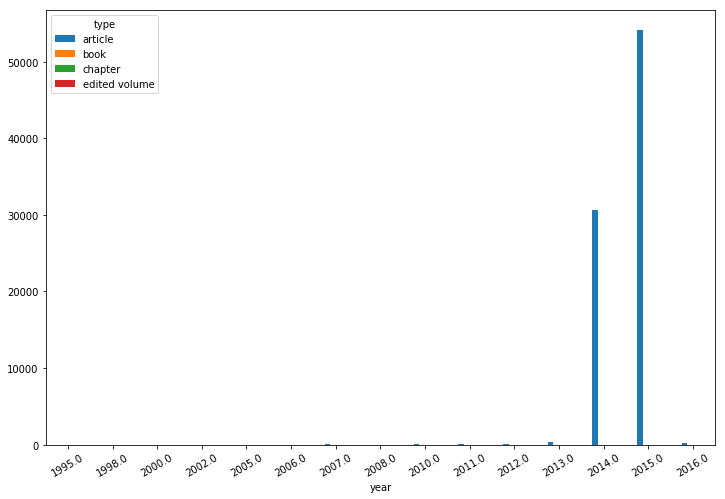

In [45]:
pd.pivot_table(
df[(df.institute=='Narodowe Centrum Badań Jądrowych_ROOT') & (df.module=='AR')], \
    values = 'title',
    index='year', columns='type',aggfunc='count').fillna(0).applymap(int).plot.bar(rot=30, figsize=(12,8))

## Co-authored works - National Centre for Nuclear Research

In [49]:
df['coauthored'] = df.nauthors > 1

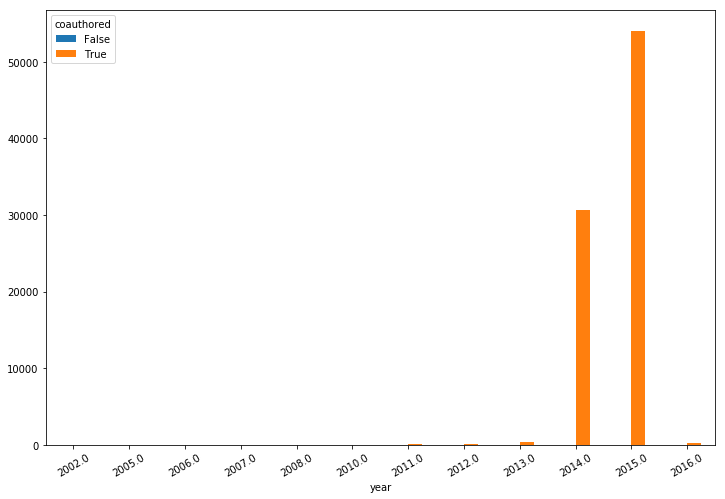

In [51]:
pd.pivot_table(
    df[(df.institute=='Narodowe Centrum Badań Jądrowych_ROOT') & (df.year > 2000)],
    index='year', columns='coauthored', aggfunc='count', values='title' ).fillna(0).applymap(int).plot.bar(rot=30, figsize=(12,8))

## Co-authored works - Lodz University of Technology

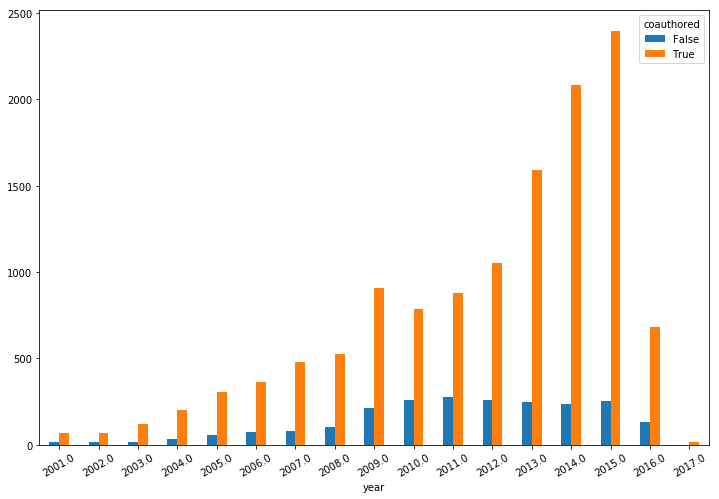

In [52]:
pd.pivot_table(
    df[(df.institute=='Politechnika Łódzka_ROOT') & (df.year > 2000)],
    index='year', columns='coauthored', aggfunc='count', values='title' ).fillna(0).applymap(int).plot.bar(rot=30, figsize=(12,8))

## Particular author analysis

In [53]:
%%time
df[df.author == 'Emanuel Kulczycki'].head(10)

CPU times: user 180 ms, sys: 359 µs, total: 180 ms
Wall time: 178 ms


,author,institute,lang,module,nauthors,title,type,year,coauthored
724,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet Gdański,en,AR,10,information and media literacy of polish child...,chapter,2014.0,True
364,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,1,wykorzystanie mediów społecznościowych przez a...,chapter,2012.0,False
580,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,en,AR,10,information and media literacy of polish child...,chapter,2014.0,True
599,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,1,teoretyzowanie komunikacji,book,2012.0,False
604,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,2,komunikologia. teoria i praktyka komunikacji,edited volume,2012.0,True
607,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,3,język – rozumienie – komunikacja”,edited volume,2011.0,True
612,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,9,dzieci sieci 2.0: kompetencje komunikacyjne mł...,book,2013.0,True
618,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,1,sytuacja komunikacyjna w kulturze archaicznej ...,article,2012.0,False
619,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,pl,AR,1,kulturowo-obiektywne istnienie procesu komunik...,article,2011.0,False
620,Emanuel Kulczycki,Wydział Nauk Społecznych_Uniwersytet im Adama ...,en,AR,1,the development of leibniz’s considerations in...,article,2009.0,False


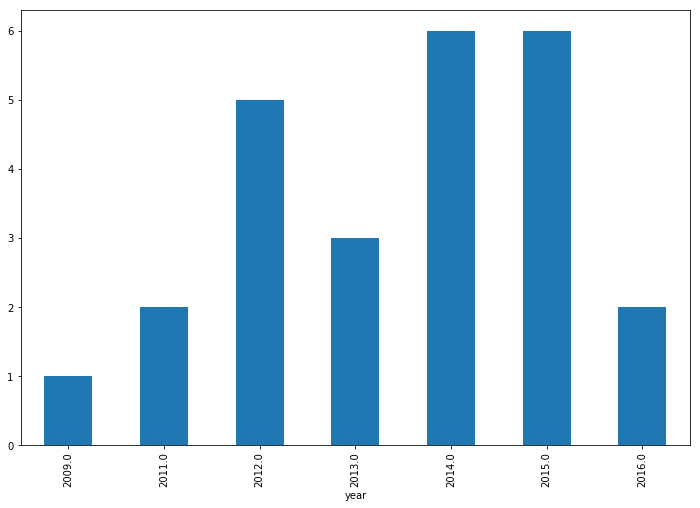

In [55]:
df[(df.author == 'Emanuel Kulczycki')&(df.module=='AR')].groupby('year')['year'].count().apply(int).plot(kind='bar', figsize=(12,8))

In [56]:
df.author.nunique()

199195

## GWO assignments

In [ ]:
%%time
df=pd.read_csv('data.csv.gz',index_col=0)

Read GWOs raw mappings

In [ ]:
pd.read_csv('GWOs.txt', sep='|', names=['lp', 'institute', 'code'], index_col=0).head()

Institutes names processsing:

* all to lower case
* remove _ROOT
* remove all punctuations
* remove single letters and "sp", "oo"
* "paostwowy" -> "państwowy"
* %s/[^a-ząęóśłżźćńĄĘÓŚŁŻŹĆŃ |0-9]//g
* ń -> o

In [ ]:
def processInstituteName(ins):
    res = ins.lower()
    res = re.sub(r'_root', '', res)
    res = re.sub(r'[^a-ząęóśłżźćńĄĘÓŚŁŻŹĆŃ |0-9]', ' ', res)
    res = re.sub(r'\b\w{1,2}\b', ' ', res)
    res = re.sub(r' +', ' ', res)
    res = res.split()
    res.sort()
    res = ' '.join(res)
    #res = re.sub(r'ń', 'o', res)
    return res

In [ ]:
INSTITUTES_MAPPIGS = {}
for line in open('GWOs.txt', 'r').readlines():
    institute, code = line.strip().split('|')
    institute = processInstituteName(institute)
    # print(institute)
    INSTITUTES_MAPPIGS[institute] = code

In [ ]:
print(INSTITUTES_MAPPIGS)

In [ ]:
df['institute'].head()

In [ ]:
def institute2code(ins):
    res = processInstituteName(ins)
    if res in INSTITUTES_MAPPIGS:
        return INSTITUTES_MAPPIGS[res]
    return None

#print(institute2code('Akademia Leona Koźmińskiego w Warszawie_ROOT'))

if True:
    for i in df['institute'].head():
        print(institute2code(i))

In [ ]:
%%time
df['gwo'] = df['institute'].map(institute2code)

In [ ]:
#df.to_csv('data-GWOs-mapped.csv')

In [ ]:
df.head(40)

In [ ]:
df[df['gwo'].isnull()]['institute'].unique()  # .to_csv('institutes-not-mapped.csv')

In [ ]:
df['institute'].unique().size

## Works only - without duplicates for each author  (dataset B)

In [ ]:
ns = '{http://pbn.nauka.gov.pl/-/ns/bibliography}'

def process_file(f):
    m = re.match(r'^(S|R|RS|AR)_(.*)_\d+\.xml', os.path.basename(f))
    if not m:
        raise Exception()
    
    results = []
    
    record = {}
    record['module'] = m.group(1)
    record['institute'] = m.group(2)
    
    root = xml.etree.ElementTree.parse(f).getroot()
    for w in root:
        record['type'] = re.sub(r'.*}', '', w.tag)
        record['title'] = w.find(ns + 'title').text.strip().lower()
        try:
            record['lang'] = w.find(ns + 'lang').text.strip().lower()
        except Exception:
            record['lang'] = ''
        record['year'] = w.find(ns + 'publication-date')
        if record['year'] != None and record['year'].text != None:
            record['year'] = record['year'].text
            record['year'] = re.sub(r'(\d\d\d\d)-.*', r'\1', record['year'])
        try:
            nothers = int(w.find(ns + 'other-contributors').text)
        except Exception:
            nothers = 0
        if record['type'] == 'book' and w.findall(ns + 'editor'):
            record['type'] = 'edited volume'   
        authors = []
        authorselems = w.findall(ns + 'author') + w.findall(ns + 'editor')
        if record['type'] == 'edited volume':
            authorselems = w.findall(ns + 'editor')
        for a in authorselems:
            try:
                fullname  = a.find(ns+'given-names').text.strip().capitalize()
                fullname += ' '
                fullname += a.find(ns+'family-name').text.strip().capitalize()
                authors.append(fullname)
            except Exception:
                # This happens if there is first name or surname information missing in XML
                pass
        record['nauthors'] = len(authors) + nothers
        
        if False: # or 'show data':
            print(record['module'])
            print(record['institute'])
            print(record['lang'])
            print(record['year'])
            print(record['type'] + ': ' + record['title'])
            print(record['nauthors'])
            for a in authors:
                print(a)
            print('--')
            
        if not 'skip "author" and avoid duplicates':
            for a in authors:
                record['author'] = a
                results.append(dict(record))
        else:
            results.append(dict(record))
            
    return results
      
f = 'ExportData/AR_Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej_126.xml'
process_file(f)

In [ ]:
%%time

df = pd.DataFrame()
for f in glob.glob('ExportData/*.xml'):
    df = df.append(pd.DataFrame(process_file(f)))

In [ ]:
df.head()

In [ ]:
%%time
df['gwo'] = df['institute'].map(institute2code)

In [ ]:
df.head()

In [ ]:
df.size

In [ ]:
df.shape


In [ ]:
df.to_csv('data-no-duplicates.csv')

In [ ]:
df

## OECD mappings

In [ ]:
oecd = pd.read_csv('GWO_OECD.csv', index_col=0, usecols=['GWO','Dziedzina OECD'])
oecd.columns = ['OECD']

In [ ]:
oecd['OECD']

In [ ]:
%%time
df=pd.read_csv('data-GWOs-mapped.csv.gz',index_col=0)

In [ ]:
df

In [ ]:
oecd.ix['nz1r'.upper()]['OECD']

In [ ]:
def gwo2oecd(gwo):
    try:
        return int(oecd.ix[gwo.upper()]['OECD'])
    except Exception:
        return None

In [ ]:
%%time
df['oecd'] = df['gwo'].map(gwo2oecd)

In [ ]:
df.head()

In [ ]:
df.to_csv('dataset-B.csv')
#df.to_csv('data-B.csv')

## Check something about authors vs editors

In [ ]:
ns = '{http://pbn.nauka.gov.pl/-/ns/bibliography}'

def check_author_vs_editor(f):
    m = re.match(r'^(S|R|RS|AR)_(.*)_\d+\.xml', os.path.basename(f))
    if not m:
        raise Exception()
    
    results = []
    
    record = {}
    record['module'] = m.group(1)
    record['institute'] = m.group(2)
    
    root = xml.etree.ElementTree.parse(f).getroot()
    first_work = True
    for w in root:
        record['type'] = re.sub(r'.*}', '', w.tag)
        if record['type'] != 'book' and w.findall(ns + 'editor'):
            title = w.find(ns + 'title').text.strip().lower()
            print(title)
        continue
        
        if w.findall(ns + 'author') and w.findall(ns + 'editor'):
            if first_work:
                print(f + ':')
                first_work = False
            title = w.find(ns + 'title').text.strip().lower()
            print(title)
            continue
    if not first_work:
        print()
        
f = 'ExportData/AR_Wydział Inżynierii Bezpieczeństwa Pożarowego_Szkoła Główna Służby Pożarniczej_126.xml'
check_author_vs_editor(f)

In [ ]:
for f in glob.glob('ExportData/*.xml'):
    check_author_vs_editor(f)

In [ ]:
df.ix[252]

## Dataset C

In [ ]:
df.head()

In [ ]:
%%time
datasetC = df.drop_duplicates(['title', 'year'])
del datasetC['institute']

In [ ]:
print(df.shape)
print(datasetC.shape)

In [ ]:
print(df.shape)
print(datasetC.shape)

In [ ]:
datasetC.head()

In [ ]:
datasetC.to_csv('dataset-C.csv')